In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install transformers==2.1.1

     |████████████████████████████████| 317kB 5.0MB/s 
     |████████████████████████████████| 1.0MB 51.6MB/s 
     |████████████████████████████████| 870kB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=5647e6882d80008a29559baccdfcd19f29ddfb424ff94e9ab409b0e19a81db43
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
!pip install fastai==1.0.58

     |████████████████████████████████| 245kB 5.1MB/s 
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successfully uninstalled fastai-1.0.59


In [0]:
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import pickle
import math
import random
import os
from pathlib import Path
from functools import partial

In [0]:
# torch
import torch
import torch.optim as optim
import torch.nn.functional as F

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PretrainedConfig, PreTrainedModel, PreTrainedTokenizer
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
from transformers import AdamW

In [0]:
# Remember to define the model dir in GDrive for persistence if using Colab
MAIN_DIR = Path("drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small")
GENERATE_SCRIPT = MAIN_DIR/'run_generation.py'

# Prepared data
DATA_FILE = MAIN_DIR/'data'/'data.pkl'

# Model checkpoints will be stored here
OUTPUT_DIR = MAIN_DIR/'output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Dumps will be stored here
DUMPS_DIR = MAIN_DIR/"dumps"
DUMPS_DIR.mkdir(exist_ok=True)

In [0]:
# Hyperparameters
MODEL_TYPE = 'gpt2'
MODEL_NAME = 'gpt2'
MODEL_CLASS = GPT2LMHeadModel
TOKENIZER_CLASS = GPT2Tokenizer
CONFIG_CLASS = GPT2Config

SEED = 42
VALID_FRAC = 0.1
USE_FP16 = False
MAX_BLOCK_SIZE = 128
BS = 16

In [0]:
# The temperature is “creativity” and allows the network to more likely make suboptimal predictions
# temperature of 0 implies greedy sampling
TEMPS = [0.7, 1, 1.3]
# Nucleus Sampling
# https://github.com/minimaxir/gpt-2-simple/issues/51
TOP_PS = [0, 0.9]
NUM_SAMPLES = 50

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  # needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(SEED)

## Import data

In [0]:
with open(DATA_FILE, 'rb') as handle:
    data = pickle.load(handle)

## Prepare data

In [0]:
tokenizer = TOKENIZER_CLASS.from_pretrained(MODEL_NAME)

100%|██████████| 456318/456318 [00:00<00:00, 1710914.20B/s]


In [0]:
def convert_text_to_ids(text):
    """Process text, tokenize it, and convert to ids for the use in GPT-2."""
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text) + [tokenizer.eos_token])

In [0]:
ids = [convert_text_to_ids(text) for text in tqdm(data)]

100%|██████████| 335082/335082 [00:38<00:00, 8605.44it/s]


In [0]:
print(data[0])
print(ids[0])

Why do showers cause amnesia?
[5195, 466, 32290, 2728, 716, 31401, 30, 50256]


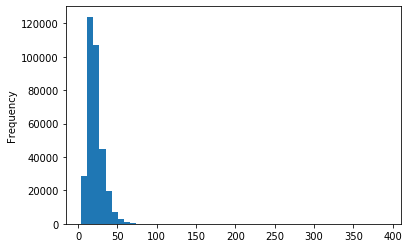

In [0]:
pd.Series(ids).apply(len).plot.hist(bins=50)

In [0]:
def split_ids_into_blocks(ids):
    """Split ids into equally-sized blocks. No padding."""
    flat_ids = [id for sentence_ids in ids for id in sentence_ids]
    inputs = []
    # Truncate in block of MAX_BLOCK_SIZE
    # Note that we are losing the last truncated example here
    for i in tqdm(range(0, len(flat_ids)-MAX_BLOCK_SIZE+1, MAX_BLOCK_SIZE)):
        inputs.append(flat_ids[i:i+MAX_BLOCK_SIZE])
    return inputs

In [0]:
features = split_ids_into_blocks(ids)

100%|██████████| 57611/57611 [00:00<00:00, 85725.40it/s]


In [0]:
pd.Series(features).apply(len).describe()

count    57611.0
mean       128.0
std          0.0
min        128.0
25%        128.0
50%        128.0
75%        128.0
max        128.0
dtype: float64

In [0]:
train_size = 1-math.floor(VALID_FRAC * len(features))
train_features = features[:train_size]
valid_features = features[train_size:]

print(len(train_features), len(valid_features))

51851 5760


In [0]:
class FeaturesDataset(Dataset):
    """Class for loading features."""
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, item):
        return torch.tensor(self.features[item]), torch.tensor(self.features[item])

In [0]:
train_ds = FeaturesDataset(train_features)
valid_ds = FeaturesDataset(valid_features)

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=BS, num_workers=1)

print(data.one_batch()[0].shape)

torch.Size([16, 128])


## Train model

In [0]:
!nvidia-smi

Tue Jan  7 16:55:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
class GPT2Model(nn.Module):
    """Wrap transformer model to access only logits."""
    def __init__(self, transformer_model: PreTrainedModel):
        super(GPT2Model, self).__init__()
        self.transformer = transformer_model
        
    def forward(self, inputs):
        # Loss is handled by transformers
        return self.transformer(inputs, labels=inputs)[0] # loss

In [0]:
# Update hyperparameters
config = CONFIG_CLASS.from_pretrained(MODEL_NAME)
config.use_bfloat16 = USE_FP16

print(config)

100%|██████████| 176/176 [00:00<00:00, 96471.18B/s]

{
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bfloat16": false,
  "vocab_size": 50257
}



In [0]:
# Download the model
transformer_model = MODEL_CLASS.from_pretrained(MODEL_NAME, config=config)
gpt2_model = GPT2Model(transformer_model=transformer_model)

In [0]:
loss_func = lambda output, target: output # our model outputs only loss
learner = Learner(data, gpt2_model, loss_func=loss_func)

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if USE_FP16: learner = learner.to_fp16()

In [0]:
# To use discriminative layer training and gradual unfreezing, split the model into groups.
print(learner.model)

GPT2Model(
  (transformer): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
       

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-05
Min loss divided by 10: 4.37E-04


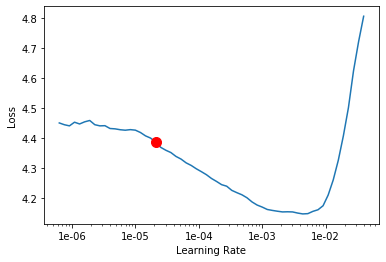

In [0]:
learner.recorder.plot(skip_end=10, suggestion=True)
# A good upper bound is not on the lowest point, but about a factor of 10 to the left.
# A good lower bound is the upper bound, divided by a factor 6.

epoch,train_loss,valid_loss,time
0,3.509815,3.484581,17:25


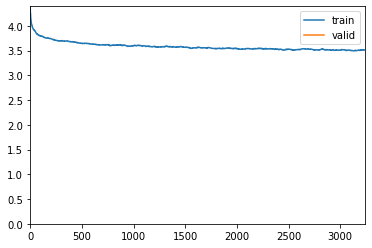

In [0]:
learner.fit(1, lr=3e-4)

In [0]:
# Save model and tokenizer
learner.model.transformer.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

('drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small-fastai/output/vocab.json',
 'drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small-fastai/output/merges.txt',
 'drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small-fastai/output/special_tokens_map.json',
 'drive/My Drive/Colab Notebooks/textai/RedditTitles/GPT2-small-fastai/output/added_tokens.json')

In [0]:
!ls "$OUTPUT_DIR"

added_tokens.json  merges.txt	      special_tokens_map.json  vocab.json
config.json	   pytorch_model.bin  tokenizer_config.json


## References

- How GPT-2 works:
    - [The Illustrated GPT-2 (Visualizing Transformer Language Models)](http://jalammar.github.io/illustrated-gpt2/)
    - [TRANSFORMERS FROM SCRATCH](http://www.peterbloem.nl/blog/transformers)
- Practical applications:
    - [Code and UI for running a Magic card text generator API via GPT-2](https://github.com/minimaxir/mtg-gpt-2-cloud-run)
- Using Huggingface:
    - [Quick Start](https://huggingface.co/transformers/quickstart.html)
- Practical tips:
    - [How to fit GPT-2 into GPU](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)
    - [Good default GPT-2 parameters](https://github.com/minimaxir/gpt-2-simple/blob/master/gpt_2_simple/gpt_2.py)
    - [Language model fine-tuning script](https://github.com/huggingface/transformers/blob/master/examples/run_lm_finetuning.py)
    - [Text generation script](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py)
    - [Optimizer Schedules](https://huggingface.co/transformers/main_classes/optimizer_schedules.html)
    - [What’s up with Deep Learning optimizers since Adam?](https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0)
    - [Adaptive - and Cyclical Learning Rates using PyTorch](https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee)
    - [The 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html)
- fastai:
    - [Fastai with 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2)
    - [Fastai documentation](https://docs.fast.ai/text.html)
    - [Fine-Tuning GPT-2 from Human Preferences](https://openai.com/blog/fine-tuning-gpt-2/)